In [1]:
import torch
import torchvision
from torch import nn
from torchvision import models, datasets, transforms
import time
from tqdm.auto import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
def set_requires_grad(model, value=False):
    for param in model.parameters():
        param.requires_grad = value

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def validation(model, dataloaders):
        model.eval()   # Set model to evaluate mode
        running_loss = 0.0
        running_corrects = 0
        
        # Iterate over data.
        n_batches = len(dataloaders['val'])
        for inputs, labels in tqdm(dataloaders['val'], total=n_batches):
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            # forward
            # track history if only in train
            with torch.set_grad_enabled(False):
                # Get model outputs and calculate loss
                # Special case for inception because in training it has an auxiliary output. In train
                #   mode we calculate the loss by summing the final output and the auxiliary output
                #   but in testing we only consider the final output.
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders['val'].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders['val'].dataset)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format('val', epoch_loss, epoch_acc))


In [3]:
num_classes = 10
input_size = 224
batch_size = 4

In [4]:
model = models.resnet18(pretrained=True)
set_requires_grad(model, False)
count_parameters(model)

0

In [5]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
count_parameters(model)

5130

In [6]:
normalize = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [7]:
# Load and preparing CIFAR10 dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=normalize)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=normalize)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)
loaders = {'train': trainloader, 'val': testloader}
classes_name_cifar10 = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# Load dataset Imagenette
dataset_path = "imagenette2"
if not os.path.exists(dataset_path):
    !wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
    !tar xvzf imagenette2.tgz
trainset_imagenette = datasets.ImageFolder(root='./%s/train/' % dataset_path, 
                                           transform=normalize)
trainloader_imagenette = torch.utils.data.DataLoader(trainset_imagenette, 
                                                     batch_size=batch_size, 
                                                     shuffle=True, 
                                                     num_workers=2)
testset_imagenette = datasets.ImageFolder(root='./%s/val/' % dataset_path, 
                                          transform=normalize)
testloader_imagenette = torch.utils.data.DataLoader(testset_imagenette, 
                                                    batch_size=batch_size, 
                                                    shuffle=True, 
                                                    num_workers=2)
loaders_imagenette = {'train': trainloader_imagenette, 'val': testloader_imagenette}
# classes for Imagenette
classes_name_imagenette = ('tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', \
                'garbage truck', 'gas pump', 'golf ball', 'parachute')

Files already downloaded and verified
Files already downloaded and verified


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
model = model.to(device)
pretrain_optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [11]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=3):
    since = time.time()

    acc_history = {'train': [], 'val': []}
    loss_history = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = len(dataloaders[phase])
            for inputs, labels in tqdm(dataloaders[phase], total=n_batches):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            loss_history[phase].append(epoch_loss)
            acc_history[phase].append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return model, acc_history

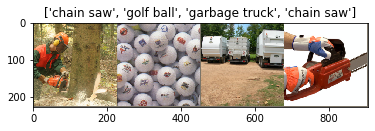

In [12]:
# Get a batch of training data
# inputs contains 4 images because batch_size=4 for the dataloaders

inputs, classes = next(iter(loaders_imagenette['val']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[classes_name_imagenette[x] for x in classes])

In [13]:
# Pretrain
model, accuracy = train_model(model, loaders_imagenette, criterion, pretrain_optimizer, num_epochs=2)

Epoch 0/1
----------



train Loss: 0.4741 Acc: 0.8586



val Loss: 0.0660 Acc: 0.9781

Epoch 1/1
----------



train Loss: 0.3438 Acc: 0.8983



val Loss: 0.0542 Acc: 0.9832

Training complete in 1m 25s


In [15]:
# Train
set_requires_grad(model, True)
train_optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model, accuracy = train_model(model, loaders_imagenette, criterion, train_optimizer, num_epochs=1)

Epoch 0/0
----------



train Loss: 0.4954 Acc: 0.8539



val Loss: 0.2740 Acc: 0.9144

Training complete in 0m 46s


In [52]:
# save FC-weights
base_fc_weight = torch.clone(model.fc.weight.data)
base_fc_weight.requires_grad = True

In [ ]:
# pretrained model in Imagenette dataset, val Loss: 0.2740 Acc: 0.9144

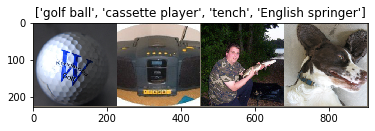

In [24]:
# predictions visualisation
inputs, classes = next(iter(loaders_imagenette['train']))
inputs = inputs.to(device)
outputs = model(inputs)
_, preds = torch.max(outputs, 1)
preds = preds.to('cpu')
inputs = inputs.to('cpu')
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[classes_name_imagenette[x] for x in preds])

In [27]:
set_requires_grad(model, False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
count_parameters(model.fc)

5130

In [28]:
model.fc.weight

Parameter containing:
tensor([[ 0.0419, -0.0013,  0.0109,  ...,  0.0057,  0.0322,  0.0416],
        [ 0.0077, -0.0376,  0.0205,  ..., -0.0218, -0.0349, -0.0225],
        [ 0.0071, -0.0070, -0.0315,  ..., -0.0144, -0.0306,  0.0395],
        ...,
        [ 0.0282, -0.0335, -0.0413,  ..., -0.0393,  0.0096,  0.0434],
        [ 0.0192, -0.0065,  0.0316,  ..., -0.0393,  0.0089,  0.0347],
        [-0.0217, -0.0340, -0.0379,  ...,  0.0282,  0.0157,  0.0384]],
       requires_grad=True)

In [31]:
# Pretrain
pretrain_optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
model = model.to(device)
model, accuracy = train_model(model, loaders, criterion, pretrain_optimizer, num_epochs=2)

Epoch 0/1
----------



train Loss: 1.2819 Acc: 0.5806



val Loss: 1.0405 Acc: 0.6724

Epoch 1/1
----------



train Loss: 1.2692 Acc: 0.5849



val Loss: 0.9718 Acc: 0.6850

Training complete in 2m 23s


In [32]:
model.fc.weight

Parameter containing:
tensor([[-0.0452, -0.0131,  0.0571,  ..., -0.1622,  0.0759,  0.0272],
        [-0.0309,  0.3594,  0.1686,  ...,  0.1802,  0.0100, -0.3089],
        [-0.1149, -0.1281, -0.1236,  ..., -0.0712,  0.0664,  0.2300],
        ...,
        [-0.2074, -0.1270,  0.1746,  ..., -0.2432,  0.0709,  0.1687],
        [ 0.0777,  0.0961, -0.0699,  ...,  0.0562,  0.2396,  0.3366],
        [ 0.0274, -0.0419, -0.1459,  ...,  0.3298, -0.0474, -0.0942]],
       device='cuda:0', requires_grad=True)

In [33]:
# Train
set_requires_grad(model, True)
train_optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model, accuracy = train_model(model, loaders, criterion, train_optimizer, num_epochs=1)

Epoch 0/0
----------



train Loss: 0.7355 Acc: 0.7681



val Loss: 0.3306 Acc: 0.8930

Training complete in 2m 60s


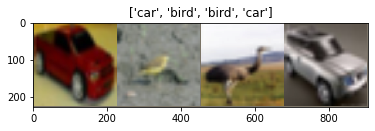

In [35]:
# predictions visualisation on CIFAR10, val Loss: 0.2746 Acc: 0.9110

inputs, classes = next(iter(loaders['train']))
inputs = inputs.to(device)
outputs = model(inputs)
_, preds = torch.max(outputs, 1)
preds = preds.to('cpu')
inputs = inputs.to('cpu')
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[classes_name_cifar10[x] for x in preds])

In [62]:
set_requires_grad(model, False)
model.fc.weight.data = base_fc_weight
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, num_classes)
model.fc.weight.requires_grad = True


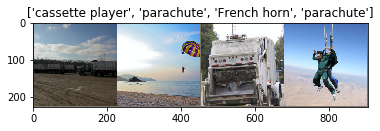

In [60]:
inputs, classes = next(iter(loaders_imagenette['train']))
inputs = inputs.to(device)
outputs = model(inputs)
_, preds = torch.max(outputs, 1)
preds = preds.to('cpu')
inputs = inputs.to('cpu')
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[classes_name_imagenette[x] for x in preds])

In [55]:
# testing model quality after addin old fc-classification layer.

validation(model, loaders_imagenette)


val Loss: 1.4285 Acc: 0.5631


In [56]:
# trainin only last fc layer
set_requires_grad(model.fc, True)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, num_classes)

In [57]:
count_parameters(model)

5130

In [63]:
pretrain_optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
model, accuracy = train_model(model, loaders_imagenette, criterion, pretrain_optimizer, num_epochs=2)

Epoch 0/1
----------



train Loss: 0.9467 Acc: 0.7019



val Loss: 0.5931 Acc: 0.8054

Epoch 1/1
----------



train Loss: 0.8164 Acc: 0.7447



val Loss: 0.5206 Acc: 0.8425

Training complete in 1m 23s


In [64]:
# testing model quality after train fc-classification layer.

validation(model, loaders_imagenette)


val Loss: 0.5206 Acc: 0.8425


In [ ]:
# Вернуть первоначальное качество не удалось, точность сети была 0.98 при обучении только fc-слоя, сейчас 0.84